In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification

In [2]:
import pickle

In [3]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.6.0


In [4]:
from sklearn import datasets
#noise = 100
noise = 1
n_features = 100

X, y = datasets.make_regression(n_samples=500, n_features=n_features, noise=noise)
#X1, y1 = datasets.make_moons(n_samples=200, noise=no)
#X11 = np.array([[x + 2, yy] for x, yy in X1])
#X = np.concatenate((X, X11), axis=0)
#y = np.concatenate((y, y1), axis=0)
#print(X.shape)
# plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
# plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
# plt.show()

# plt.scatter(X, y)
# plt.show()


In [5]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))
# plt.plot(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], 'g^')
# plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], 'bs')
# plt.show()
# plt.plot(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0], 'g^')
# plt.plot(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], 'bs')
# plt.show()

len train: 400
len test: 100


In [6]:
BATCH_SIZE = 32

training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).float())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Define accuracy & Model

In [7]:
def accuracy(model, test_loader, l=200):
#     correct = 0
#     losses = []
#     for examples, labels in test_loader:
#         output = model.forward(examples)
#         batch_correct = torch.sum(torch.abs(torch.flatten(output) - labels) < 0.5)
#         losses.append(nn.BCELoss()(torch.flatten(output), labels))
#         correct += batch_correct

#     acc = float(correct)/l
#     loss = sum(losses)/len(losses)
#     return acc, loss
    return 1.0

def accuracy_per_data(model, inputs, labels):
    inp = Variable(inputs, requires_grad=True)
    outputs = model.forward(inp)
    loss = nn.BCELoss()(torch.squeeze(outputs), labels)
    correct = torch.sum(torch.abs(torch.flatten(outputs) - labels) < 0.5)
    return correct//len(inputs), loss

In [8]:
class RegressionModel(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            #nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return self.network(x)

# Define membership inference attack

In [9]:
def gaussian_pdf(sd, x):
    if sd <= 0:
        raise ValueError('standard deviation must be positive but is {}'.format(sd))
    else: #sd > 0
        return np.e ** (-0.5*(x/sd)**2) / sd


def membership_inf(model, avg_train_loss, inputs, labels):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = nn.MSELoss(reduction='none')(torch.squeeze(outputs), labels)
    pass_inf = [1 if abs(l) < avg_train_loss else 0 for l in loss]
    
    return pass_inf, [float(l) for l in loss]

In [10]:
def run_membership_inference_attack(model, avg_train_l, X_target, y_target):
    _, sensitivities = grad_immediate_sensitivity(model, 
                                                      nn.MSELoss(), 
                                                      torch.from_numpy(X_target).float(), 
                                                      torch.from_numpy(y_target).float(), 
                                                      None)
    max_sen = max(sensitivities)
    norm_sen = [s/max_sen for s in sensitivities]
    min_exp = min([np.log(s) for s in sensitivities if s != 0])
    log_sen = [np.log(s) if s !=0 else min_exp - 1 for s in sensitivities]
    paws = [s - (min_exp - 1) for s in log_sen]

    pass_inf, train_loss = membership_inf(model, 
                                          avg_train_l, 
                                          torch.from_numpy(X_target).float(), 
                                          torch.from_numpy(y_target).float())
    #plt.scatter(paws, pass_inf)
    #print('positive ratio:',sum(pass_inf)/len(pass_inf))
    return sum(pass_inf)/len(pass_inf)

# The calculation for immediate sensitivity

In [30]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch, individual_sensitivities=False):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = criterion(torch.squeeze(outputs), labels)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    if not individual_sensitivities:
        # (4) L2 norm of (3) - "immediate sensitivity"
        s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''

    loss.backward()
    
    if individual_sensitivities:
        return loss, sensitivity_vec
    else:
        return loss, s

# Train the model, calculating immediate sensitivities

In [64]:
def run_experiment(epsilon, epochs, add_noise=False, throw_out_threshold=False):
    # reset the model
    model = RegressionModel(n_features=n_features)
    model_criterion = nn.MSELoss() 
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    #epochs = 100
    #iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 25
    epsilon_iter = epsilon / epochs
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    train_accs = []
    test_losses = []
    all_batch_mean_sensitivities = []
    all_batch_max_sensitivities = []
    advs = []

    local_X_train = torch.from_numpy(X_train).float()
    local_y_train = torch.from_numpy(y_train).float()
    local_X_test = torch.from_numpy(X_test).float()
    local_y_test = torch.from_numpy(y_test).float()
    
    for epoch in range(epochs):
#         print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            plz_update = True
            
            model_optimizer.zero_grad()
            #loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch, individual_sensitivities=True)
            train_losses.append(loss)
            
            batch_sensitivities = torch.max(batch_sensitivities, 0).values
#            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
#             all_sensitivities.extend(batch_sensitivities)
#             all_batch_mean_sensitivities.append(np.mean(batch_sensitivities) / BATCH_SIZE)
#             all_batch_max_sensitivities.append(np.max(batch_sensitivities) / BATCH_SIZE)
            
            if throw_out_threshold:
                # delete gradients?
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad = None

                # throw out "bad" examples
                good_idxs = np.array(batch_sensitivities) < throw_out_threshold
                #print(len(x_batch_train[good_idxs]), 'out of', len(x_batch_train))

                # re-do the gradients
                good_xs = x_batch_train[good_idxs]
                good_ys = y_batch_train[good_idxs]
                
                if len(good_xs) / len(x_batch_train) < 0.5:
                    plz_update = False
                
                outputs = model.forward(good_xs)
                loss = model_criterion(torch.squeeze(outputs), good_ys)

                loss.backward()
                
                batch_sensitivity = min(throw_out_threshold, batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
#            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

#            sigmas.append(sigma)

            if add_noise:
                with torch.no_grad():
                    for p, s in zip(model.parameters(), batch_sensitivities):
                        sigma = np.sqrt((s**2 * alpha) / (2 * epsilon_iter))

                        p.grad += (sigma * torch.randn(1).float())

            if plz_update:
                model_optimizer.step()

#         max_sensitivities.append(np.max(all_sensitivities))
#         mean_sensitivities.append(np.mean(all_sensitivities))
#         max_sigmas.append(np.max(sigmas))        
#         mean_sigmas.append(np.mean(sigmas))
#         train_accs.append(accuracy_per_data(model, torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()))
#         test_accs.append(accuracy_per_data(model, torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()))
        
    
        lossfn = model_criterion
        avg_train_l = lossfn(torch.squeeze(model.forward(local_X_train)), local_y_train)
        avg_test_l = lossfn(torch.squeeze(model.forward(local_X_test)), local_y_test)

        train_accs.append(avg_train_l)
        test_accs.append(avg_test_l)
        
        tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)
        fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)
        adv = tpr - fpr
        advs.append(adv)
        
        #plot_decision_boundary(model, nn.BCELoss(), steps=100, title=f'Epoch {epoch}')
        
#         print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
#         print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
#         print("Max sigma for the epoch:", max_sigmas[-1])
#         print("Mean sigma for the epoch:", mean_sigmas[-1])

#         print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, 
                                          mean_sigmas, test_accs, train_accs,
                                          all_batch_mean_sensitivities, all_batch_max_sensitivities, test_losses,
                                          advs), model

# Try 1, without noise

In [99]:
final_acc, info_tuple, model = run_experiment(1, 200, True, False)

In [100]:
train_losses = info_tuple[6]
test_losses = info_tuple[5]

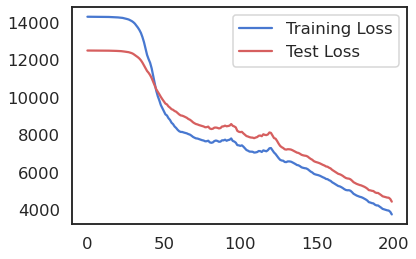

In [101]:
plt.plot(train_losses, color='b', label='Training Loss')
plt.plot(test_losses, color='r', label='Test Loss')
plt.legend()
#fig.tight_layout()
plt.show() 

In [102]:
lossfn = nn.MSELoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).float())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

print('average train loss:', avg_train_l)
print('average test loss:', avg_test_l)

average train loss: tensor(3744.0576, grad_fn=<MseLossBackward>)
average test loss: tensor(4426.8213, grad_fn=<MseLossBackward>)


# Sensitivity stats

0
0


Text(0, 0.5, 'Mean Sensitivity')

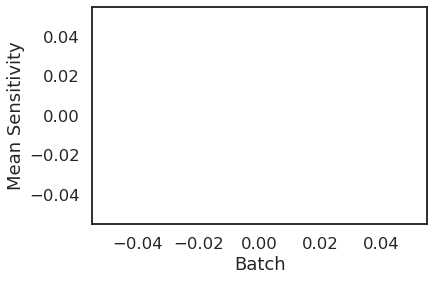

In [103]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, all_means)
batch_mean_sensitivities = info_tuple[7]
batch_max_sensitivities = info_tuple[8]
print(len(batch_max_sensitivities))
print(len(batch_mean_sensitivities))

plt.plot(batch_mean_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Mean Sensitivity")

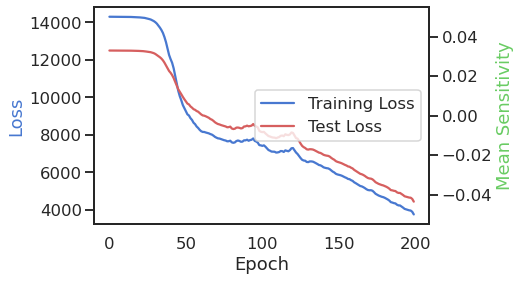

In [104]:
plt.figure()

ax1 = plt.gca()
ax1.plot(train_losses, color='b', label='Training Loss')
ax1.plot(test_losses, color='r', label='Test Loss')
ax1.legend(loc='center right')
ax1.set_ylabel('Loss', color='b')

epoch_mean_sensitivities = info_tuple[2]
ax2 = ax1.twinx()
ax2.plot(epoch_mean_sensitivities, color='g')
ax2.set_ylabel('Mean Sensitivity', color='g')

#fig.tight_layout()
ax1.set_xlabel('Epoch')
plt.show() 

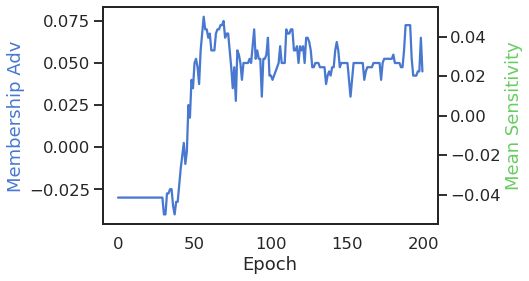

In [105]:
plt.figure()

advs = info_tuple[10]
ax1 = plt.gca()
ax1.plot(advs, color='b')
ax1.set_ylabel('Membership Adv', color='b')

epoch_mean_sensitivities = info_tuple[2]
ax2 = ax1.twinx()
ax2.plot(epoch_mean_sensitivities, color='g')
ax2.set_ylabel('Mean Sensitivity', color='g')

#fig.tight_layout()
ax1.set_xlabel('Epoch')
plt.show() 

Text(0, 0.5, 'Max Sensitivity')

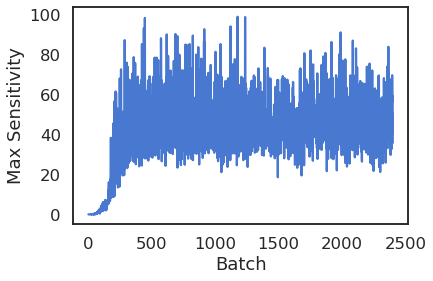

In [20]:
plt.plot(batch_max_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Max Sensitivity")

# Membership Inference Attacks

In [113]:
lossfn = nn.MSELoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).float())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

print('average train loss:', avg_train_l)
print('average test loss:', avg_test_l)

average train loss: tensor(0.0001, grad_fn=<MseLossBackward>)
average test loss: tensor(2133.8489, grad_fn=<MseLossBackward>)


In [116]:
tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)

In [117]:
fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)

In [118]:
print('Adv:', tpr - fpr)

Adv: 0.825


# Full Experiment

In [23]:
def threshold_experiment(threshold):
    final_acc, info_tuple, model = run_experiment(1, 100, False, threshold)
    avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                        torch.from_numpy(y_train).float())
    avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

    tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)
    fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)
    adv = tpr - fpr
    return adv, avg_test_l.item()

In [130]:
def plot_results(results):
    plt.figure()

    ax1 = plt.gca()
    markers, caps, bars = ax1.errorbar(results['thresholds'], 
                                       results['losses'], 
                                       results['loss_stds'], 
                                       color='b', 
                                       alpha=.8)
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax1.set_ylabel('Testing Loss', color='b')
    ax1.tick_params('x', colors='b')

    ax2 = ax1.twinx()
    markers, caps, bars = ax2.errorbar(results['thresholds'], 
                                       results['advs'], 
                                       results['adv_stds'], 
                                       color='r')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax2.set_ylabel('Membership Inference Adv', color='r')
    ax2.tick_params('x', colors='r')

    #fig.tight_layout()
    plt.show() 

In [41]:
#thresholds = [20, 50, 100, 200, 500, 1000]
thresholds = np.linspace(100, 10000, 100)
print(thresholds)
advs = []
adv_stds = []
losses = []
loss_stds = []

for threshold in thresholds:
    print('Threshold', threshold)
    results = [threshold_experiment(threshold) for _ in range(5)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')

results = {
    'thresholds': thresholds,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('big_experiment.pkl', 'wb') as f:
    pickle.dump(results, f)

[  100.   200.   300.   400.   500.   600.   700.   800.   900.  1000.
  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.  2000.
  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.  3000.
  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.  4000.
  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.  5000.
  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.  6000.
  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.  7000.
  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.  8000.
  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.  9000.
  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900. 10000.]
Threshold 100.0
Threshold 200.0
Threshold 300.0
Threshold 400.0
Threshold 500.0
Threshold 600.0
Threshold 700.0
Threshold 800.0
Threshold 900.0
Threshold 1000.0
Threshold 1100.0
Threshold 1200.0
Threshold 1300.0
Threshold 1400.0
Threshold 1500.0
Threshold 1600.0
Threshold 1700.0
Threshold

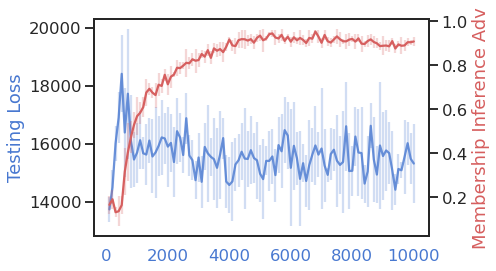

In [131]:
with open('big_experiment.pkl', 'rb') as f:
    results = pickle.load(f)
    
plot_results(results)

In [24]:
#thresholds = [20, 50, 100, 200, 500, 1000]
thresholds = np.linspace(10, 300, 30)
print(thresholds)
advs = []
adv_stds = []
losses = []
loss_stds = []

for threshold in thresholds:
    print('Threshold', threshold)
    results = [threshold_experiment(threshold) for _ in range(5)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')

[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.
 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270. 280.
 290. 300.]
Threshold 10.0


/home/jnear/anaconda3/envs/torch/lib/python3.6/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Threshold 20.0
Threshold 30.0
Threshold 40.0
Threshold 50.0
Threshold 60.0
Threshold 70.0
Threshold 80.0
Threshold 90.0
Threshold 100.0
Threshold 110.0
Threshold 120.0
Threshold 130.0
Threshold 140.0
Threshold 150.0
Threshold 160.0
Threshold 170.0
Threshold 180.0
Threshold 190.0
Threshold 200.0
Threshold 210.0
Threshold 220.0
Threshold 230.0
Threshold 240.0
Threshold 250.0
Threshold 260.0
Threshold 270.0
Threshold 280.0
Threshold 290.0
Threshold 300.0
done


In [35]:
results = {
    'thresholds': thresholds,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('mid_experiment.pkl', 'wb') as f:
    pickle.dump(results, f)

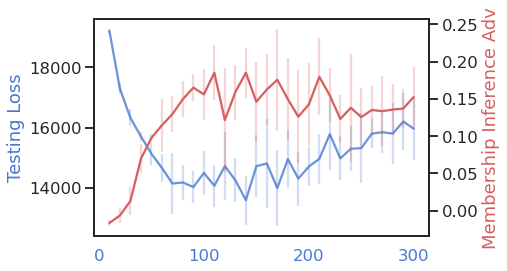

In [164]:
with open('mid_experiment.pkl', 'rb') as f:
    results = pickle.load(f)
plot_results(results)

In [175]:
results['losses'][14]

14720.7279296875

Text(0, 0.5, 'Membership Inference Adv')

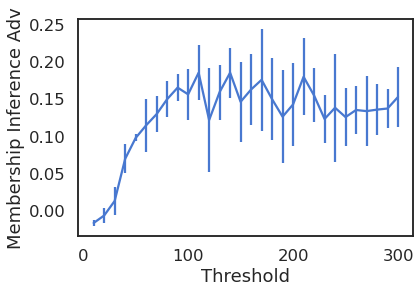

In [57]:
plt.errorbar(results['thresholds'], results['advs'], results['adv_stds'])
plt.xlabel('Threshold')
plt.ylabel('Membership Inference Adv')

Text(0, 0.5, 'Test Loss')

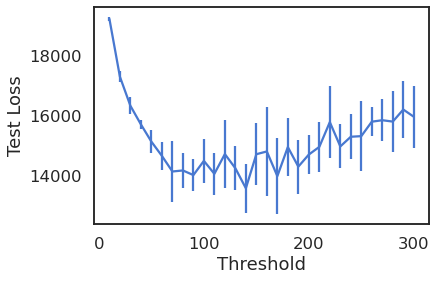

In [59]:
plt.errorbar(results['thresholds'], results['losses'], results['loss_stds'])
plt.xlabel('Threshold')
plt.ylabel('Test Loss')

# Experiment 2: Noise, no thresholding

In [60]:
def noise_experiment(threshold, epsilon):
    final_acc, info_tuple, model = run_experiment(epsilon, 100, True, threshold)
    avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                        torch.from_numpy(y_train).float())
    avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

    tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)
    fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)
    adv = tpr - fpr
    return adv, avg_test_l.item()

In [121]:
def plot_noise_results(results):
    plt.figure()

    ax1 = plt.gca()
    markers, caps, bars = ax1.errorbar(results['epsilons'], 
                                       results['losses'], 
                                       results['loss_stds'], 
                                       color='b', 
                                       alpha=.8)
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax1.set_ylabel('Testing Loss', color='b')
    ax1.tick_params('x', colors='b')

    ax2 = ax1.twinx()
    markers, caps, bars = ax2.errorbar(results['epsilons'], 
                                       results['advs'], 
                                       results['adv_stds'], 
                                       color='r')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax2.set_ylabel('Membership Inference Adv', color='r')
    ax2.tick_params('x', colors='r')

    ax1.set_xlabel('Epsilon (delta = 1e-5)')
    #fig.tight_layout()
    plt.show() 

In [45]:
def convert_rdp(alpha, epsilon, delta):
    return epsilon + (np.log(1/delta) / (alpha - 1))

for epsilon in np.linspace(0.1, 5.0, 10):
    for alpha in [25]:
        print(f'({alpha}, {epsilon}) => {convert_rdp(alpha, epsilon, 1e-5)}')

(25, 0.1) => 0.5797052277070929
(25, 0.6444444444444445) => 1.1241496721515374
(25, 1.188888888888889) => 1.668594116595982
(25, 1.7333333333333336) => 2.2130385610404266
(25, 2.277777777777778) => 2.757483005484871
(25, 2.8222222222222224) => 3.301927449929315
(25, 3.366666666666667) => 3.84637189437376
(25, 3.911111111111112) => 4.390816338818205
(25, 4.455555555555556) => 4.935260783262649
(25, 5.0) => 5.479705227707093


In [95]:
#thresholds = [20, 50, 100, 200, 500, 1000]
#thresholds = np.linspace(100, 10000, 100)
epsilons = np.linspace(0.1, 5.0, 10)
print(epsilons)
advs = []
adv_stds = []
losses = []
loss_stds = []

for epsilon in epsilons:
    print('Eps:', epsilon)
    results = [noise_experiment(False, epsilon) for _ in range(5)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')
f_eps = [convert_rdp(25, epsilon, 1e-5) for epsilon in epsilons]

results = {
    'epsilons': f_eps,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('noise_only_experiment_small.pkl', 'wb') as f:
    pickle.dump(results, f)

[0.1        0.64444444 1.18888889 1.73333333 2.27777778 2.82222222
 3.36666667 3.91111111 4.45555556 5.        ]
Eps: 0.1
Eps: 0.6444444444444445
Eps: 1.188888888888889
Eps: 1.7333333333333336
Eps: 2.277777777777778
Eps: 2.8222222222222224
Eps: 3.366666666666667
Eps: 3.911111111111112
Eps: 4.455555555555556
Eps: 5.0
done


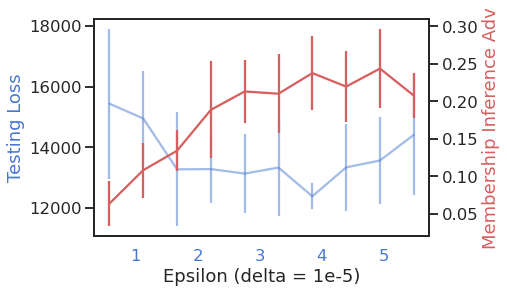

In [107]:
with open('noise_only_experiment_small.pkl', 'rb') as f:
    results = pickle.load(f)

plot_noise_results(results)

In [113]:
#thresholds = [20, 50, 100, 200, 500, 1000]
#thresholds = np.linspace(100, 10000, 100)
epsilons = np.linspace(0.01, 2.0, 40)
print(epsilons)
advs = []
adv_stds = []
losses = []
loss_stds = []

for epsilon in epsilons:
    print('Eps:', epsilon)
    results = [noise_experiment(False, epsilon) for _ in range(5)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')
f_eps = [convert_rdp(25, epsilon, 1e-5) for epsilon in epsilons]

results = {
    'epsilons': f_eps,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('noise_only_experiment_exsmall.pkl', 'wb') as f:
    pickle.dump(results, f)

[0.01       0.06102564 0.11205128 0.16307692 0.21410256 0.26512821
 0.31615385 0.36717949 0.41820513 0.46923077 0.52025641 0.57128205
 0.62230769 0.67333333 0.72435897 0.77538462 0.82641026 0.8774359
 0.92846154 0.97948718 1.03051282 1.08153846 1.1325641  1.18358974
 1.23461538 1.28564103 1.33666667 1.38769231 1.43871795 1.48974359
 1.54076923 1.59179487 1.64282051 1.69384615 1.74487179 1.79589744
 1.84692308 1.89794872 1.94897436 2.        ]
Eps: 0.01
Eps: 0.06102564102564103
Eps: 0.11205128205128205
Eps: 0.1630769230769231
Eps: 0.21410256410256412
Eps: 0.2651282051282051
Eps: 0.3161538461538462
Eps: 0.36717948717948723
Eps: 0.41820512820512823
Eps: 0.46923076923076923
Eps: 0.5202564102564102
Eps: 0.5712820512820513
Eps: 0.6223076923076923
Eps: 0.6733333333333333
Eps: 0.7243589743589745
Eps: 0.7753846153846154
Eps: 0.8264102564102564
Eps: 0.8774358974358974
Eps: 0.9284615384615384
Eps: 0.9794871794871796
Eps: 1.0305128205128204
Eps: 1.0815384615384616
Eps: 1.1325641025641027
Eps: 1.18

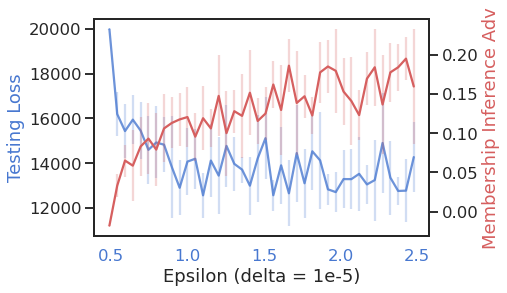

In [156]:
with open('noise_only_experiment_exsmall.pkl', 'rb') as f:
    results = pickle.load(f)

plot_noise_results(results)

In [63]:
#thresholds = [20, 50, 100, 200, 500, 1000]
#thresholds = np.linspace(100, 10000, 100)
epsilons = np.linspace(1.0, 100.0, 10)
print(epsilons)
advs = []
adv_stds = []
losses = []
loss_stds = []

for epsilon in epsilons:
    print('Eps:', epsilon)
    results = [noise_experiment(False, epsilon) for _ in range(5)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')
f_eps = [convert_rdp(25, epsilon, 1e-5) for epsilon in epsilons]

results = {
    'epsilons': f_eps,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('noise_only_experiment_med.pkl', 'wb') as f:
    pickle.dump(results, f)

[  1.  12.  23.  34.  45.  56.  67.  78.  89. 100.]
Eps: 1.0
Eps: 12.0
Eps: 23.0
Eps: 34.0
Eps: 45.0
Eps: 56.0
Eps: 67.0
Eps: 78.0
Eps: 89.0
Eps: 100.0
done


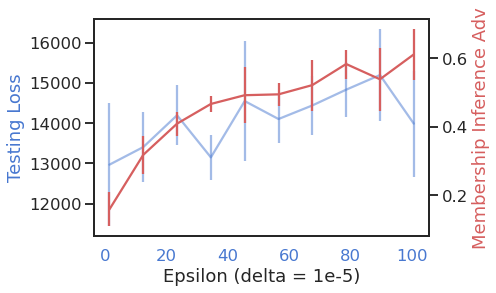

In [108]:
with open('noise_only_experiment_med.pkl', 'rb') as f:
    results = pickle.load(f)

plot_noise_results(results)

In [61]:
#thresholds = [20, 50, 100, 200, 500, 1000]
#thresholds = np.linspace(100, 10000, 100)
epsilons = np.linspace(100.0, 1000.0, 10)
print(epsilons)
advs = []
adv_stds = []
losses = []
loss_stds = []

for epsilon in epsilons:
    print('Eps:', epsilon)
    results = [noise_experiment(False, epsilon) for _ in range(5)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')
f_eps = [convert_rdp(25, epsilon, 1e-5) for epsilon in epsilons]

results = {
    'epsilons': f_eps,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('noise_only_experiment_lg.pkl', 'wb') as f:
    pickle.dump(results, f)

[ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000.]
Eps: 100.0
Eps: 200.0
Eps: 300.0
Eps: 400.0
Eps: 500.0
Eps: 600.0
Eps: 700.0
Eps: 800.0
Eps: 900.0
Eps: 1000.0
done


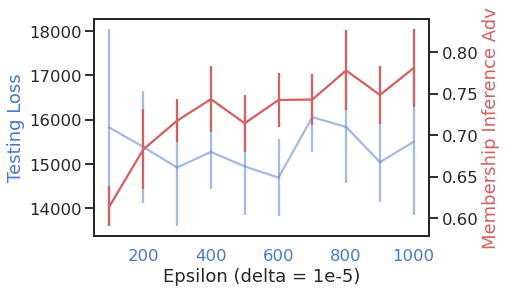

In [109]:
with open('noise_only_experiment_lg.pkl', 'rb') as f:
    results = pickle.load(f)

plot_noise_results(results)

In [128]:
#thresholds = [20, 50, 100, 200, 500, 1000]
#thresholds = np.linspace(100, 10000, 100)
epsilons = np.linspace(1.0, 1000.0, 100)
print(epsilons)
advs = []
adv_stds = []
losses = []
loss_stds = []

for epsilon in epsilons:
    print('Eps:', epsilon)
    results = [noise_experiment(False, epsilon) for _ in range(5)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')
f_eps = [convert_rdp(25, epsilon, 1e-5) for epsilon in epsilons]

results = {
    'epsilons': f_eps,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('noise_only_experiment_wide.pkl', 'wb') as f:
    pickle.dump(results, f)

[   1.           11.09090909   21.18181818   31.27272727   41.36363636
   51.45454545   61.54545455   71.63636364   81.72727273   91.81818182
  101.90909091  112.          122.09090909  132.18181818  142.27272727
  152.36363636  162.45454545  172.54545455  182.63636364  192.72727273
  202.81818182  212.90909091  223.          233.09090909  243.18181818
  253.27272727  263.36363636  273.45454545  283.54545455  293.63636364
  303.72727273  313.81818182  323.90909091  334.          344.09090909
  354.18181818  364.27272727  374.36363636  384.45454545  394.54545455
  404.63636364  414.72727273  424.81818182  434.90909091  445.
  455.09090909  465.18181818  475.27272727  485.36363636  495.45454545
  505.54545455  515.63636364  525.72727273  535.81818182  545.90909091
  556.          566.09090909  576.18181818  586.27272727  596.36363636
  606.45454545  616.54545455  626.63636364  636.72727273  646.81818182
  656.90909091  667.          677.09090909  687.18181818  697.27272727
  707.36363636

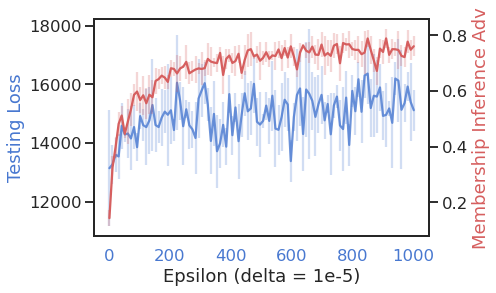

In [129]:
with open('noise_only_experiment_wide.pkl', 'rb') as f:
    results = pickle.load(f)

plot_noise_results(results)

# Experiment 3: combo

In [137]:
#thresholds = [20, 50, 100, 200, 500, 1000]
#thresholds = np.linspace(100, 10000, 100)
epsilons = np.linspace(0.1, 10.0, 30)
print(epsilons)
advs = []
adv_stds = []
losses = []
loss_stds = []
threshold = 150

for epsilon in epsilons:
    print('Eps:', epsilon)
    results = [noise_experiment(threshold, epsilon) for _ in range(10)]
    results = list(zip(*results))
    
    advs.append(np.mean(results[0]))
    adv_stds.append(np.std(results[0]))
    losses.append(np.mean(results[1]))
    loss_stds.append(np.std(results[1]))

print('done')
f_eps = [convert_rdp(25, epsilon, 1e-5) for epsilon in epsilons]

results = {
    'epsilons': f_eps,
    'advs': advs,
    'adv_stds': adv_stds,
    'losses': losses,
    'loss_stds': loss_stds
}
with open('combo_experiment_wide.pkl', 'wb') as f:
    pickle.dump(results, f)

[ 0.1         0.44137931  0.78275862  1.12413793  1.46551724  1.80689655
  2.14827586  2.48965517  2.83103448  3.17241379  3.5137931   3.85517241
  4.19655172  4.53793103  4.87931034  5.22068966  5.56206897  5.90344828
  6.24482759  6.5862069   6.92758621  7.26896552  7.61034483  7.95172414
  8.29310345  8.63448276  8.97586207  9.31724138  9.65862069 10.        ]
Eps: 0.1
Eps: 0.4413793103448276
Eps: 0.7827586206896552
Eps: 1.124137931034483
Eps: 1.4655172413793105
Eps: 1.806896551724138
Eps: 2.148275862068966
Eps: 2.4896551724137934
Eps: 2.831034482758621
Eps: 3.1724137931034484
Eps: 3.513793103448276
Eps: 3.855172413793104
Eps: 4.196551724137931
Eps: 4.537931034482758
Eps: 4.879310344827586
Eps: 5.220689655172413
Eps: 5.562068965517241
Eps: 5.903448275862069
Eps: 6.244827586206896
Eps: 6.586206896551724
Eps: 6.927586206896551
Eps: 7.268965517241379
Eps: 7.610344827586207
Eps: 7.951724137931034
Eps: 8.293103448275863
Eps: 8.63448275862069
Eps: 8.975862068965517
Eps: 9.317241379310344


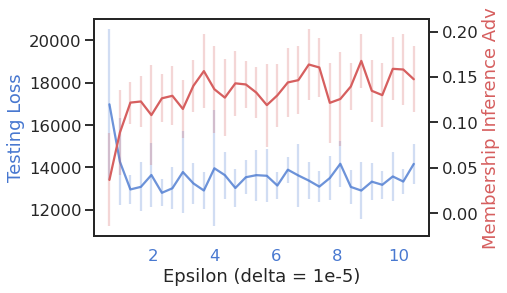

In [150]:
with open('combo_experiment_wide.pkl', 'rb') as f:
    results = pickle.load(f)

plot_noise_results(results)

In [155]:
results['epsilons'][5]

2.2866017794312308

# Try 2, with noise

In [170]:
final_acc, info_tuple, model = run_experiment(5.0, 200, True, 80)

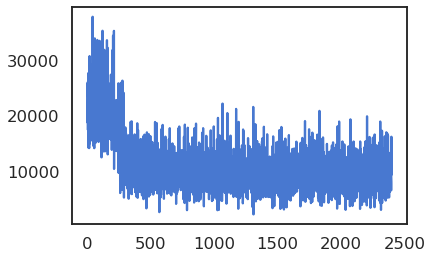

In [171]:
plt.plot(info_tuple[0])

In [172]:
lossfn = nn.MSELoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).float())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

print('average test loss:', avg_test_l)

average test loss: tensor(14958.0791, grad_fn=<MseLossBackward>)


In [173]:
tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)

positive ratio: 0.7575


In [174]:
fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)

positive ratio: 0.62


In [175]:
print('Adv:', tpr - fpr)

Adv: 0.13749999999999996


2400
2400


Text(0, 0.5, 'Mean Sensitivity')

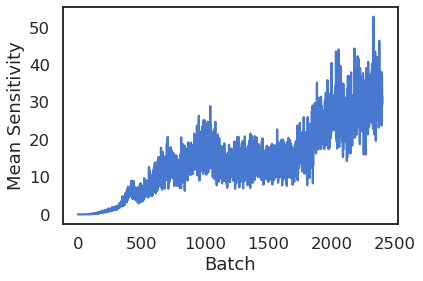

In [71]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, all_means)
batch_mean_sensitivities = info_tuple[7]
batch_max_sensitivities = info_tuple[8]
print(len(batch_max_sensitivities))
print(len(batch_mean_sensitivities))

plt.plot(batch_mean_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Mean Sensitivity")

Text(0, 0.5, 'Max Sensitivity')

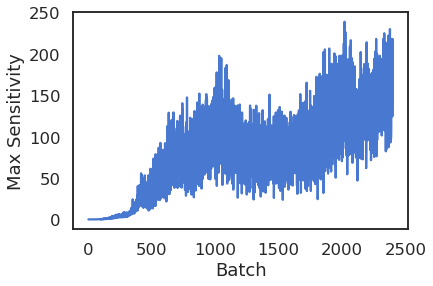

In [72]:
plt.plot(batch_max_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Max Sensitivity")